In [9]:
import numpy as np
import matplotlib.pyplot as plt
from modularities_notebooks.modularity import clustered_connections, print_weight_matrix, compute_density_matrix, plot_connection_matrices
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sys

if '/Users/svenkerstjens/DataSpell/lib/python3.9/site-packages' not in sys.path:
    sys.path.append('/Users/svenkerstjens/DataSpell/lib/python3.9/site-packages')
import torch
import snn_utils
from randman.randman import *
import matplotlib.pyplot as plt
import seaborn as sns
from randman_utils import *
from torch.utils.data import DataLoader, Dataset
from typing import Optional

from Selfish_RNN import sparse_rnn_core as srnn

In [3]:
from LIFlayer import OneHiddenModel,OneRecHiddenModel,NHiddenModel

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'device: {device}')
else:
    device = torch.device("cpu")
    print(f'device: {device}')

device: cuda


In [5]:
class RandmanDataset(Dataset):
    """Characterizes a PyTorch dataset for use with the PyTorch dataloader."""
    def __init__(self, data, labels):
        """Simple initialization of the given dataset."""
        self.data = data
        self.labels = labels

    def __len__(self):
        """Denotes the total number of samples"""
        return len(self.labels)

    def __getitem__(self, index):
        """Retrives a single sample from the given dataset."""
        # Load data and get label
        X = self.data[index]
        y = self.labels[index]

        return X, y

def convert_spike_times_to_raster(spike_times: np.ndarray, timestep: float = 1.0, max_time: Optional[float] = None, num_neurons: Optional[int] = None, dtype=None):
    """
    Convert spike times array to spike raster array. 
    For now, all neurons need to have same number of spike times.
    
    Args:
        spike_times: MoreArrays, spiketimes as array of shape (batch_dim x spikes/neuron X 2)
            with final dim: (times, neuron_id)
    """

    if dtype is None:
        dtype = np.int16
    # spike_times = spike_times.astype(np.uint16)
    if num_neurons is None:
        num_neurons = int(np.nanmax(spike_times[:,:,1]))+1
    if max_time is None:
        max_time = np.nanmax(spike_times[:,:,0])
    num_bins = int(max_time / timestep + 1)

    spike_raster = np.zeros((spike_times.shape[0], num_bins, num_neurons), dtype=np.float32)
    batch_id = np.arange(spike_times.shape[0]).repeat(spike_times.shape[1])
    spike_times_flat = (spike_times[:, :, 0].flatten() / timestep).astype(dtype)
    neuron_ids = spike_times[:, :, 1].flatten().astype(dtype)
    np.add.at(spike_raster, (batch_id, spike_times_flat, neuron_ids), 1)
    return spike_raster


def make_spike_raster_dataset(nb_classes=10, nb_units=100, nb_steps=100, dim_manifold=2, nb_samples=1000, alpha=2.0, shuffle=True, seed=None):
# def make_spike_raster_dataset(nb_classes, nb_units, nb_steps, dim_manifold=2, nb_spikes=1, nb_samples=1000, alpha=2.0, shuffle=True):
# def make_spike_raster_dataset():
    spike_times,labels = make_spiking_dataset(nb_classes=nb_classes, nb_units=nb_units, nb_steps=nb_steps, dim_manifold=dim_manifold, seed=seed,nb_samples=nb_samples,shuffle=shuffle,alpha=alpha)
    spike_raster = convert_spike_times_to_raster(spike_times)
    return spike_raster, labels

def get_data_loaders(nb_classes, nb_units, nb_steps, nb_samples, batchsize):
    data, labels = make_spike_raster_dataset(nb_classes=nb_classes, nb_units=nb_units, nb_steps=nb_steps, nb_samples=nb_samples)

    NUM_SAMPLES_TOTAL = (nb_classes*nb_samples)
    NUM_SAMPLES_TRAIN = int(NUM_SAMPLES_TOTAL*0.8)

    data_train, labels_train = data[:NUM_SAMPLES_TRAIN], labels[:NUM_SAMPLES_TRAIN]
    data_test,  labels_test  = data[NUM_SAMPLES_TRAIN:], labels[NUM_SAMPLES_TRAIN:]

    dataset_train = RandmanDataset(data_train, labels_train)
    dataset_test = RandmanDataset(data_test, labels_test)

    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True, drop_last=True)
    dataloader_test = DataLoader(dataset_test, batch_size=batchsize, shuffle=True, drop_last=True)
    return dataloader_train, dataloader_test

In [10]:
N_CLASSES = 2
T_STEPS = 100
IN_SIZE = 100
SAMPLES_PER_CLASS = 1000
BATCH_SIZE = 50
EPOCHS = 100
dataloader_train, dataloader_test = get_data_loaders(N_CLASSES,IN_SIZE,T_STEPS,SAMPLES_PER_CLASS,BATCH_SIZE)

In [12]:
model = NHiddenModel(1,100,100,2)

decay = srnn.CosineDecay(.3,len(dataloader_train)*EPOCHS)
optimizer = torch.optim.SGD(model.parameters(),lr=1)

mask = srnn.Masking(optimizer, death_rate_decay=decay)
mask.add_module(model, density=.25)

dataloader_train, dataloader_test = get_data_loaders(4,400,100,1000,50)

Removed 4 layers.
layers.0.fc_layer.weight 0
layers.1.fc_layer.weight 0
layers.1.rec_layer.weight 0
layers.2.fc_layer.weight 0
Death rate: 0.3



In [7]:
#def train_test(data,test_frac=.2):
#    train = data[:int(len(data)*(1-test_frac))]
#    test = data[int(len(data)*(1-test_frac)):]
#    return train,test
#
#def get_X_y(data,labels,T):
#    X_train, X_test = train_test(data)
#    y_train, y_test = train_test(labels)
#    X_train = prep_data(X_train,T=T)
#    X_test = prep_data(X_test, T=T)
#    y_train = prep_labels(y_train)
#    y_test = prep_labels(y_test)
#    return X_train, X_test, y_train,y_test
#
#def create_data(N,T,batch_size,nb_classes,nb_samples,alpha,device='cpu'):
#    data,labels = make_spiking_dataset(nb_classes=nb_classes, nb_units=N, nb_steps=T, dim_manifold=1, seed=42,nb_samples=nb_samples,shuffle=True,alpha=alpha)
#    show_samples(data,labels)
#    data = torch.IntTensor(data)
#    X_train, X_test, y_train, y_test = get_X_y(data,labels,T)
#    train_batch_ids = get_batches(X_train,batch_size)
#    test_batch_ids = get_batches(X_test,batch_size)
#    y_train = y_train.long()
#    y_test = y_test.long()
#    return torch.tensor(X_train,device=device),torch.tensor(X_test,device=device),torch.tensor(y_train,device=device),torch.tensor(y_test,device=device),torch.tensor(train_batch_ids,device=device),torch.tensor(test_batch_ids,device=device)

In [8]:
def get_Ws(N,nb_classes,epsilon=1, modularity =1,base_w = 1,w = 1,plot=True,device=device):
    n_assemblies = nb_classes
    ss = StandardScaler()
    mask, cluster_ids, _ = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=1./n_assemblies, modularity=modularity)
    mask = (mask* (base_w*w)) + base_w

    W, cluster_ids, t = clustered_connections(n_neurons=N, n_clusters=n_assemblies, density=epsilon, modularity=0.)
    if w > 0.:
        W *= base_w
        W *= mask

    if epsilon ==1:
        W = W-1
    W2 = (W != 0).astype(int)
    if plot:
        plt.figure(figsize=(6,6))
        plt.title(f'Weight Mask. N={N}; modularity={modularity}')
        plt.imshow(W,cmap='viridis')
        plt.colorbar()
        plt.show()
        plt.figure(figsize=(6,6))
        plt.title('Weight Mask: training')
        plt.imshow(W2)
        plt.colorbar()
        plt.show()
    return torch.tensor(W,device=device,dtype=torch.float32), torch.tensor(W2,device=device,dtype=torch.float32)

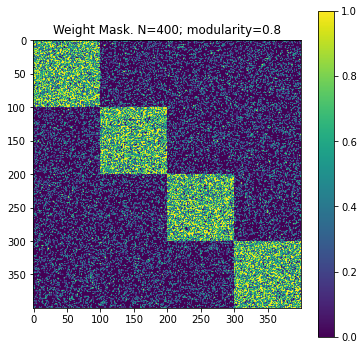

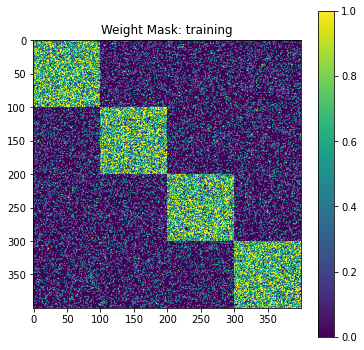

In [7]:
W,W2 = get_Ws(400,4,1,.8,1,1)

In [8]:
W.sum()

tensor(39996.)

In [13]:
def validation_acc(X_test,y_test,model,test_batch_ids):
    sum_acc = 0
    decay=.99
    count = 0
    for i in range(len(test_batch_ids)):
        model.eval()
        model.init_states()
        Sprobe = torch.zeros((batch_size,model.out_channels),device=device)
        #out = torch.zeros((batch_size,model.out_channels),device=device)
        #out_rec = [out]
        count +=1
        for n in range(T):

            out_state = model(X_test[test_batch_ids[i],n])
            #out_rec.append(out_state.U)
            Sprobe = decay * Sprobe + out_state.S

        #out_rec = torch.stack(out_rec,dim=1)
        #prediction = torch.max(out_rec,1).values
        prediction = Sprobe
        accuracy = acc_from_pred(prediction,y_test[test_batch_ids[i]])
        sum_acc = sum_acc + accuracy
    avg_acc = sum_acc/count
    return avg_acc,prediction,y_test[test_batch_ids[i]]

def acc_from_pred(prediction,y):

    return (y == prediction.argmax(axis=1)).sum()/len(prediction)

In [14]:
#def train(N,T,nb_classes,model,X_train,y_train,train_batch_ids,W,W2,lr,decay,epochs=100,use_W=False,use_W2=False,print_each=5,device='cpu'):
def train(T,dataloader_train,dataloader_test,nb_classes,model,W,W2,lr,decay=.99,epochs=100,use_W=False,use_W2=False,print_each=5,device=device):
    #in_channels=N
    #hidden_channels = N
    #out_channels = nb_classes
    #model = FiveHiddenModel(in_channels,hidden_channels,out_channels,batch_size=batch_size,W=W)

    #mse_loss = torch.nn.MSELoss()
    ce_loss = torch.nn.CrossEntropyLoss()

    #apply W
    if use_W:
        model.init_mod_weights(W)

    #layer1.fc_layer.weight = torch.nn.Parameter(torch.Tensor(W))
    params = model.parameters()
    opt = torch.optim.Adam(params, lr=lr, betas=[0., .95]) #lr is the learning rate
    loss_hist = []
    acc_hist = []
    val_hist = []
    #epochs
    for e in range(epochs):

        for Sin, target in dataloader_test: 
            model.init_states()
            Sin = Sin.to(device)
            target = target.to(device)
            Sprobe = torch.zeros((dataloader_test.batch_size,model.out_channels),device=device)
            val_hist_local = []
            with torch.no_grad():
                for n in range(T):
                    # Do not change weights during testing
                    valstate = model(Sin[:,n])
                    Sprobe = decay * Sprobe + valstate.S
                tgt = target.cpu().numpy()
                pred = Sprobe.clone().cpu().numpy()
                local_acc = acc_from_pred(pred,tgt)
                val_hist_local.append(local_acc)


        batch_loss = 0
        batch_acc=0
        model.train()

        #batches

        #if e%10 == 0:
        #    y = model.layer1.fc_layer.weight.clone().detach()
        #    plt.imshow(y)
        #    plt.show()
        #plt.imshow(W)
        #plt.show()
        count = 0
        for x,label in dataloader_train:
            model.init_states()
            Sprobe = torch.zeros((dataloader_train.batch_size,model.out_channels),device=device)
            x = x.to(device)
            label=label.to(device)
            for n in range(T):
                out_state = model(x[:,n])

                Sprobe = decay * Sprobe + out_state.S

            
            prediction = Sprobe
            accuracy = acc_from_pred(prediction,label)
            loss = ce_loss(prediction,label)
            loss.backward()
            opt.step()
            opt.zero_grad()

#        for i in range(len(train_batch_ids)):
#        
#
#            model.init_states()
#            Sprobe = torch.zeros((batch_size,model.out_channels),device=device)
#            #out = torch.zeros((batch_size,model.out_channels),device=device)
#            #out_rec = [out]
#        #timesteps
#            for n in range(T):
#                out_state = model(X_train[train_batch_ids[i],n])
#
#            #add decay for leakiness
#            #collect spikes over time
#                Sprobe = decay * Sprobe + out_state.S
#                #out_rec.append(out_state.U)
#
#            #out_rec = torch.stack(out_rec,dim=1)
#            #prediction = torch.max(out_rec,1).values
#            prediction = Sprobe
#            accuracy = acc_from_pred(prediction,y_train[train_batch_ids[i]])
#            loss = ce_loss(prediction,y_train[train_batch_ids[i]])
#
#            loss.backward()
#            opt.step()
#            opt.zero_grad()
            if use_W2:
                model.init_mod_weights(W2)
            count+=1
            batch_acc = batch_acc + accuracy
            batch_loss = batch_loss + loss
        
        val_hist.append(np.mean(val_hist_local))
        #epoch_acc = batch_acc/(len(train_batch_ids))
        epoch_acc = batch_acc/count
        epoch_loss = batch_loss/count
        #epoch_loss = batch_loss/(len(train_batch_ids))
        loss_hist = loss_hist + [float(epoch_loss)]
        acc_hist = acc_hist + [float(epoch_acc)]
        

        if e%print_each==0:
            print(f'epoch {e}: \n loss: {epoch_loss}')
            print(f'train_acc: {epoch_acc}')
    return loss_hist,acc_hist,val_hist

In [ ]:
#def train(N,T,nb_classes,model,X_train,y_train,train_batch_ids,W,W2,lr,decay,epochs=100,use_W=False,use_W2=False,print_each=5,device='cpu'):
def train_with_maskopt(T,dataloader_train,dataloader_test,nb_classes,model,W,W2,lr,decay=.99,epochs=100,use_W=False,use_W2=False,print_each=5,device=device):
    #in_channels=N
    #hidden_channels = N
    #out_channels = nb_classes
    #model = FiveHiddenModel(in_channels,hidden_channels,out_channels,batch_size=batch_size,W=W)

    #mse_loss = torch.nn.MSELoss()
    ce_loss = torch.nn.CrossEntropyLoss()

    #apply W
    if use_W:
        model.init_mod_weights(W)

    #layer1.fc_layer.weight = torch.nn.Parameter(torch.Tensor(W))
    params = model.parameters()
    opt = torch.optim.Adam(params, lr=lr, betas=[0., .95]) #lr is the learning rate
    loss_hist = []
    acc_hist = []
    val_hist = []
    #epochs
    for e in range(epochs):

        for Sin, target in dataloader_test: 
            model.init_states()
            Sin = Sin.to(device)
            target = target.to(device)
            Sprobe = torch.zeros((dataloader_test.batch_size,model.out_channels),device=device)
            val_hist_local = []
            with torch.no_grad():
                for n in range(T):
                    # Do not change weights during testing
                    valstate = model(Sin[:,n])
                    Sprobe = decay * Sprobe + valstate.S
                tgt = target.cpu().numpy()
                pred = Sprobe.clone().cpu().numpy()
                local_acc = acc_from_pred(pred,tgt)
                val_hist_local.append(local_acc)


        batch_loss = 0
        batch_acc=0
        model.train()

        #batches

        #if e%10 == 0:
        #    y = model.layer1.fc_layer.weight.clone().detach()
        #    plt.imshow(y)
        #    plt.show()
        #plt.imshow(W)
        #plt.show()
        count = 0
        for x,label in dataloader_train:
            model.init_states()
            Sprobe = torch.zeros((dataloader_train.batch_size,model.out_channels),device=device)
            x = x.to(device)
            label=label.to(device)
            for n in range(T):
                out_state = model(x[:,n])

                Sprobe = decay * Sprobe + out_state.S

            
            prediction = Sprobe
            accuracy = acc_from_pred(prediction,label)
            loss = ce_loss(prediction,label)
            loss.backward()
            opt.step()
            opt.zero_grad()

#        for i in range(len(train_batch_ids)):
#        
#
#            model.init_states()
#            Sprobe = torch.zeros((batch_size,model.out_channels),device=device)
#            #out = torch.zeros((batch_size,model.out_channels),device=device)
#            #out_rec = [out]
#        #timesteps
#            for n in range(T):
#                out_state = model(X_train[train_batch_ids[i],n])
#
#            #add decay for leakiness
#            #collect spikes over time
#                Sprobe = decay * Sprobe + out_state.S
#                #out_rec.append(out_state.U)
#
#            #out_rec = torch.stack(out_rec,dim=1)
#            #prediction = torch.max(out_rec,1).values
#            prediction = Sprobe
#            accuracy = acc_from_pred(prediction,y_train[train_batch_ids[i]])
#            loss = ce_loss(prediction,y_train[train_batch_ids[i]])
#
#            loss.backward()
#            opt.step()
#            opt.zero_grad()
            if use_W2:
                model.init_mod_weights(W2)
            count+=1
            batch_acc = batch_acc + accuracy
            batch_loss = batch_loss + loss
        
        val_hist.append(np.mean(val_hist_local))
        #epoch_acc = batch_acc/(len(train_batch_ids))
        epoch_acc = batch_acc/count
        epoch_loss = batch_loss/count
        #epoch_loss = batch_loss/(len(train_batch_ids))
        loss_hist = loss_hist + [float(epoch_loss)]
        acc_hist = acc_hist + [float(epoch_acc)]
        

        if e%print_each==0:
            print(f'epoch {e}: \n loss: {epoch_loss}')
            print(f'train_acc: {epoch_acc}')
    return loss_hist,acc_hist,val_hist

In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'device: {device}')
else:
    device = torch.device("cpu")
    print(f'device: {device}')

device: cuda


created 16 batches
created 4 batches


/tmp/ipykernel_2161447/4236364291.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X_train,device=device),torch.tensor(X_test,device=device),torch.tensor(y_train,device=device),torch.tensor(y_test,device=device),torch.tensor(train_batch_ids,device=device),torch.tensor(test_batch_ids,device=device)


TypeError: __init__() got an unexpected keyword argument 'batch_size'

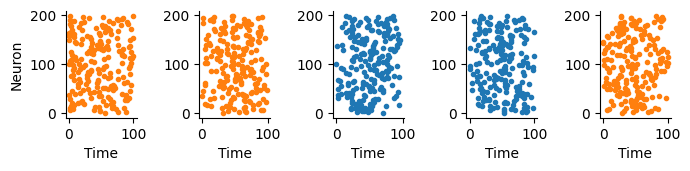

In [ ]:
N=200
T=100
batch_size=100
nb_classes=2
#W,W2 = get_Ws(N=N,nb_classes=nb_classes,epsilon=1,device=device)

X_train,X_test,y_train, y_test, train_batch_ids,test_batch_ids =create_data(N=N,T=T,batch_size=batch_size,nb_classes=nb_classes,nb_samples=1000,alpha=1.5,device=device)
model = OneRecHiddenModel(in_channels=N,hidden_channels=N,out_channels=nb_classes,batch_size=batch_size,device=device)

AttributeError: 'DataLoader' object has no attribute 'device'

In [ ]:
from LIFlayer import NHiddenModel

model = NHiddenModel(num_hidden_layers=1,in_channels=200,hidden_channels=200,out_channels=4,with_recurrent=True).to(device)

In [ ]:
layer1_out = np.array(1000 * 4 * 0.8)
global j = 0
def hook(m,i,o):
    
    layer1_out[j] = o.S.detach().cpu().numpy()
    j += 1


In [12]:
import pandas as pd
w_test = torch.ones_like(W,device=device)

In [14]:
w_test

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [13]:
W

tensor([[1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [27]:
model.layers


[0, 1]

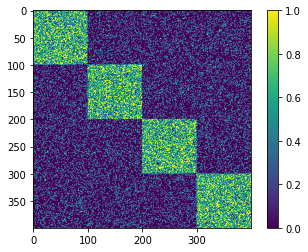

In [13]:
plt.imshow(W)
plt.colorbar()

In [19]:
model.init_mod_weights()

Signature: model.init_mod_weights(W)
Docstring: <no docstring>
File:      ~/msc_thesis/msc_thesis/LIFlayer.py
Type:      method


In [20]:
model = NHiddenModel(num_hidden_layers=1,in_channels=400,hidden_channels=400,out_channels=4,with_recurrent=False).to(device)
loss, acc, val = train(T=100,dataloader_train=dataloader_train,dataloader_test=dataloader_test,nb_classes=4,epochs=10, model=model,use_W=True,use_W2=True,lr=1e-4,decay=.99,W=W,W2=W,print_each=1,device=device)

epoch 0: 
 loss: 1.4487649202346802
train_acc: 0.25718748569488525
epoch 1: 
 loss: 1.3868976831436157
train_acc: 0.26625001430511475
epoch 2: 
 loss: 1.3711459636688232
train_acc: 0.31562498211860657
epoch 3: 
 loss: 1.3377609252929688
train_acc: 0.3734374940395355
epoch 4: 
 loss: 1.2547316551208496
train_acc: 0.5112500786781311
epoch 5: 
 loss: 1.176300048828125
train_acc: 0.5678125023841858
epoch 6: 
 loss: 1.0610783100128174
train_acc: 0.6450001001358032
epoch 7: 
 loss: 0.8949100971221924
train_acc: 0.7409374713897705
epoch 8: 
 loss: 0.7417953014373779
train_acc: 0.809999942779541
epoch 9: 
 loss: 0.5538278818130493
train_acc: 0.9140622019767761


In [23]:
#plt.imshow(model.layers[1].fc_layer.weight.data)
#plt.colorbar()
(model.layers[2].fc_layer.weight.data != 0).sum()

tensor(1600)

In [24]:
results = {}
for num_hidden_layers in [1,2,3,4,5]:
    for repetition in range(3):
        print(f'layers: {num_hidden_layers}; repetition: {repetition} ----------------------------')
        model = NHiddenModel(num_hidden_layers=num_hidden_layers,in_channels=400,hidden_channels=400,out_channels=4,with_recurrent=False).to(device)
        loss, acc, val = train(T=100,dataloader_train=dataloader_train,dataloader_test=dataloader_test,nb_classes=4,epochs=40, model=model,use_W=True,use_W2=True,lr=1e-4,decay=.99,W=W,W2=W,print_each=1,device=device)
        results[f'{num_hidden_layers}-loss-{repetition}'] = loss
        results[f'{num_hidden_layers}-train-{repetition}'] = acc
        results[f'{num_hidden_layers}-val-{repetition}'] = val
        with open(f'rep-{repetition}-mask-no_rec.pkl', 'wb') as f:
            pickle.dump(results, f)
        


layers: 1; repetition: 0 ----------------------------
epoch 0: 
 loss: 1.4168051481246948
train_acc: 0.28406253457069397
epoch 1: 
 loss: 1.2567137479782104
train_acc: 0.41343748569488525
epoch 2: 
 loss: 1.0349235534667969
train_acc: 0.66343754529953
epoch 3: 
 loss: 0.9445655345916748
train_acc: 0.7665625214576721
epoch 4: 
 loss: 0.9061904549598694
train_acc: 0.7646876573562622
epoch 5: 
 loss: 0.7618895769119263
train_acc: 0.8362500667572021
epoch 6: 
 loss: 0.5677071213722229
train_acc: 0.908437192440033
epoch 7: 
 loss: 0.3994632959365845
train_acc: 0.9678122401237488
epoch 8: 
 loss: 0.27362579107284546
train_acc: 0.9862498641014099
epoch 9: 
 loss: 0.1909320205450058
train_acc: 0.9906249046325684
epoch 10: 
 loss: 0.11430715769529343
train_acc: 0.9984374642372131
epoch 11: 
 loss: 0.07054051011800766
train_acc: 1.0
epoch 12: 
 loss: 0.04474445804953575
train_acc: 0.9993749856948853
epoch 13: 
 loss: 0.027193846181035042
train_acc: 1.0
epoch 14: 
 loss: 0.01559117529541254
train

In [ ]:
import pickle

with open('no_rec_with_mask_17-05.pkl', 'wb') as f:
    pickle.dump(results, f)

In [70]:
with open('no_rec_no_mask_17-05.pkl', 'rb') as f:
    loaded_dict2 = pickle.load(f)

In [84]:
import pandas as pd

df = pd.DataFrame(loaded_dict2)

In [35]:
[f'1-loss-{i}' for i in range(5)]

['1-loss-0', '1-loss-1', '1-loss-2', '1-loss-3', '1-loss-4']

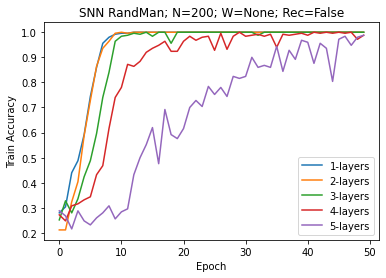

In [74]:

for j in [1,2,3,4,5]:
    plt.plot(df[[f'{j}-val-{i}' for i in range(5)]].mean(axis=1),label=f'{j}-layers')
plt.title('SNN RandMan; N=200; W=None; Rec=False')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.legend()

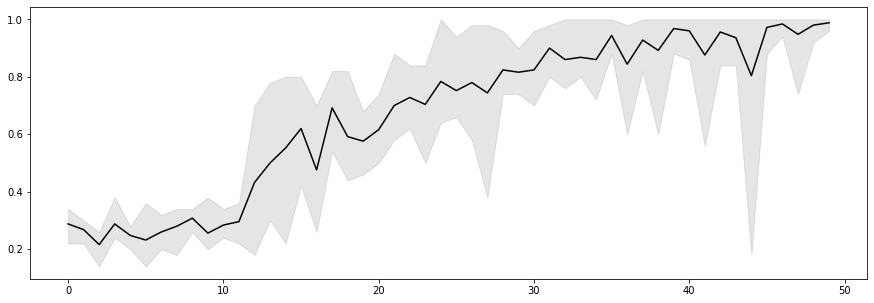

In [135]:
fig, ax = plt.subplots(1, 3)
plt.rcParams["figure.figsize"] = (15,5)

fig.suptitle('5-layer runs')

for i,metric in enumerate(['loss','train','val']):

    fig.fill_between(df[val_list].index,df[val_list].min(axis=1),df[val_list].max(axis=1),color='gray',alpha=.2)
    fig.plot(df[val_list].mean(axis=1),color='black')

In [128]:
val_list = [f'5-val-{i}' for i in range(5)]

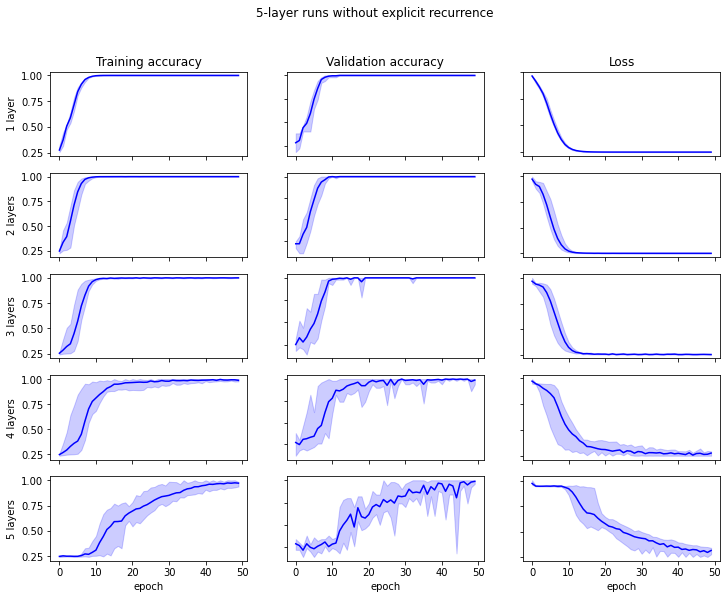

In [178]:
fig, axs = plt.subplots(5, 3)
plt.rcParams["figure.figsize"] = (12,9)
colors = ['blue','blue','blue','blue','blue']
fig.suptitle('5-layer runs without explicit recurrence')
for j,layers in enumerate(range(1,6)):
    color = colors[j]
    for i,metric in enumerate(['train','val','loss']):
        columns = [f'{layers}-{metric}-{k}' for k in range(5)]
        axs[j,i].fill_between(df[columns].index,df[columns].min(axis=1),df[columns].max(axis=1),color=color,alpha=.2)
        axs[j,i].plot(df[columns].mean(axis=1),color=color)
        #axs[j,i].set_title(metric)
        axs[j,i].set(xlabel='epoch', ylabel=f'{layers} layers',label=f'{layers} layers')


axs[0,0].set_title('Training accuracy')
axs[0,1].set_title('Validation accuracy')
axs[0,2].set_title('Loss')
axs[0,0].set(ylabel='1 layer')
for ax in axs.flat:
    ax.label_outer()



In [153]:
range?

Init signature: range(self, /, *args, **kwargs)
Docstring:     
range(stop) -> range object
range(start, stop[, step]) -> range object

Return an object that produces a sequence of integers from start (inclusive)
to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
These are exactly the valid indices for a list of 4 elements.
When step is given, it specifies the increment (or decrement).
Type:           type
Subclasses:     


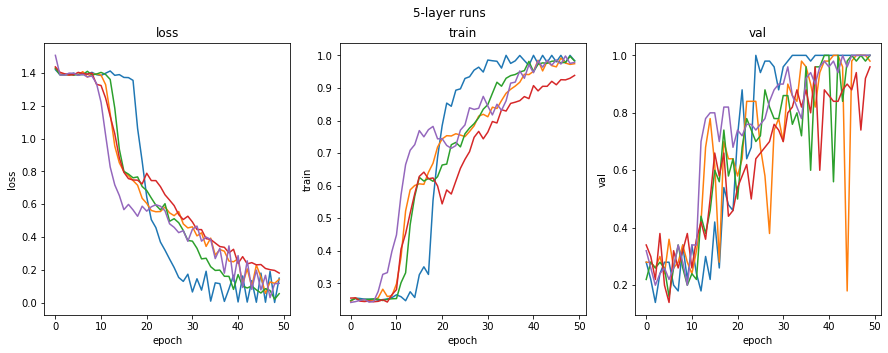

In [136]:
fig, ax = plt.subplots(1, 3)
plt.rcParams["figure.figsize"] = (15,5)

fig.suptitle('5-layer runs')

for i,metric in enumerate(['loss','train','val']):
    columns = [f'5-{metric}-{i}' for i in range(5)]
    ax[i].plot(df[columns])
    ax[i].set_title(metric)
    ax[i].set(xlabel='epoch', ylabel=metric)


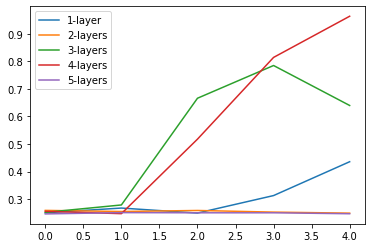

In [ ]:
plt.plot(results['1_l_train_acc'], label='1-layer')
plt.plot(results['2_l_train_acc'], label='2-layers')
plt.plot(results['3_l_train_acc'], label='3-layers')
plt.plot(results['4_l_train_acc'], label='4-layers')
plt.plot(results['5_l_train_acc'], label='5-layers')
plt.legend()

In [ ]:
loss, acc, val = train(T=100,dataloader_train=dataloader_train,dataloader_test=dataloader_test,nb_classes=4,epochs=10, model=model,use_W=False,use_W2=False,lr=1e-4,decay=.99,W=W,W2=W2,print_each=1,device=device)

epoch 0: 
 loss: 1.4493379592895508
train_acc: 0.28624993562698364
epoch 1: 
 loss: 1.3524487018585205
train_acc: 0.35531243681907654
epoch 2: 
 loss: 1.2499358654022217
train_acc: 0.4303124248981476
epoch 3: 
 loss: 0.859282910823822
train_acc: 0.7584375739097595
epoch 4: 
 loss: 0.42305490374565125
train_acc: 0.9499998688697815
epoch 5: 
 loss: 0.19158607721328735
train_acc: 0.9743748903274536
epoch 6: 
 loss: 0.06273745000362396
train_acc: 0.9934375286102295
epoch 7: 
 loss: 0.13779573142528534
train_acc: 0.971250057220459
epoch 8: 
 loss: 0.014892269857227802
train_acc: 1.0
epoch 9: 
 loss: 0.0048794131726026535
train_acc: 1.0


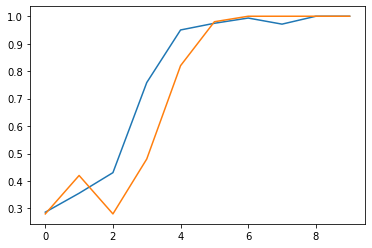

In [ ]:
plt.plot(acc)
plt.plot(val)

In [ ]:
layer1_out = np.array(layer1_out)

/tmp/ipykernel_2457769/1731042577.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  layer1_out = np.array(layer1_out)


In [ ]:
model.layers[1].register_forward_hook(hook)

In [ ]:
loss, acc = train(N,T,nb_classes,model,X_train,y_train,train_batch_ids,W=W,W2=W2,lr=1e-4,decay=.99,use_W=True,use_W2=True,print_each=5,epochs=100,device=device)

NameError: name 'N' is not defined

In [ ]:
model.layer2.fc_layer.weight.data.device

device(type='cuda', index=0)

In [ ]:
val_acc,_,_ = validation_acc(X_test,y_test,model,test_batch_ids)
#val_acc_hist = val_acc_hist + [val_acc]
print(f'val_acc: {val_acc}')

val_acc: 1.0


torch.Size([800, 100, 100])

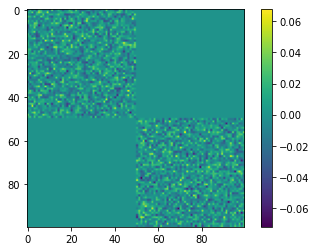

In [ ]:
plt.imshow(model.layer2.fc_layer.weight.data.cpu())
plt.colorbar()

In [ ]:
data1, data2 = get_data_loaders(4,200,100,1000,50)

In [ ]:
data1.


50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
